In [68]:
from matplotlib import pyplot as plt
import os
from scipy.io.wavfile import read
import scipy
from scipy import stats
import numpy as np
import torch
import json
import librosa 
from librosa.feature import melspectrogram
import scaleogram as scg 
from logmmse import logmmse_from_file
import pywt
import pickle
import seaborn as sns
from scipy.stats import kurtosis, skew
import pandas as pd
import sys
from AEspeech import AEspeech
import cv2
import librosa
from librosa.feature import melspectrogram
# from phonetGM2 import Phonet
from SpecDatset import SpecDataset

In [69]:
from SpecDatset import SpecDataset
import sklearn
import time
import torch
import numpy as np
import pandas as pd
import os
import sys
from CAE import CAEn
PATH=os.getcwd()
sys.path.append(PATH+"/toolbox/")
import traintestsplit as tts

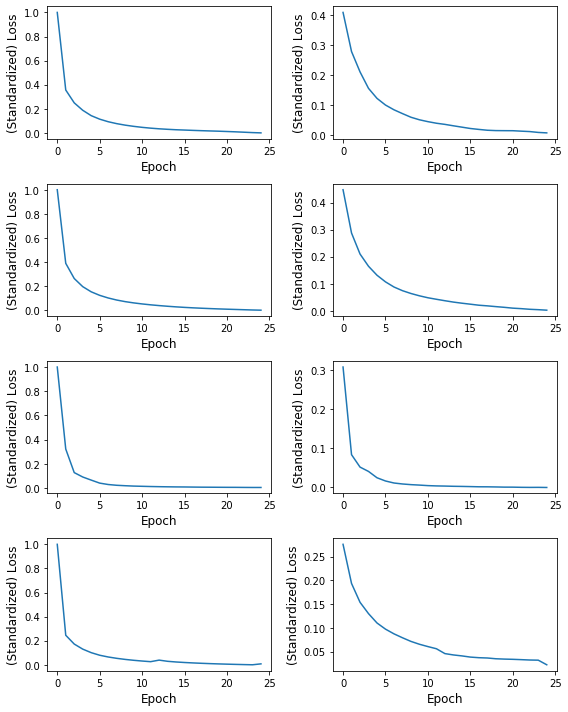

In [3]:
#Visualize training, validation results and reconstruction error for pd vs. hc speakers for all utterance types.
mods=['CAE']
reps=['broadband','narrowband', 'wvlt', 'mc_fuse'] #'bb/nb/mc_fuse' => mfccs, 'wvlt' => wavelet coefficients as features
outs=['training','validation']
bns=256

fig,ax=plt.subplots(nrows=len(reps)*len(mods),ncols=len(outs), figsize=(8,10))
current_ax=-1
for nmod,mod in enumerate(mods):
    for nrep,rep in enumerate(reps):
        load_path=PATH+'/pts/'+rep+'/'+'loss_'+str(bns)+'_'+mod+'.csv'
        with open(load_path, 'rb') as handle:
            data = pd.read_csv(handle, header=None)
        current_ax+=1
                    
        for i,out in enumerate(outs):
            ax_curr=ax[current_ax][i]
            data=(data-np.min(np.min(data)))/(np.max(np.max(data))-np.min(np.min(data)))
            ax_curr.plot(data.iloc[:,i])

#             if i==0:
#                 ax_curr.set_title(mod+" "+rep+": "+out+" loss",fontsize=16)
#             else:
#                 ax_curr.set_title(mod+" "+rep+": "+out+" loss")
            ax_curr.set_ylabel("(Standardized) Loss",fontsize=12)
            ax_curr.set_xlabel("Epoch",fontsize=12)
            plt.tight_layout()

Text(0, 0.5, 'Standardized Mel Filter Weights')

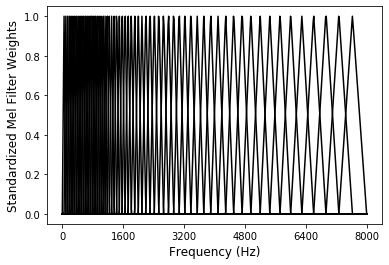

In [67]:
"""
Visualize Mel-frequency bands for narrowband (higher freq. resolution: n_mels=128) 
and broadband (lower freq. resolution: n_mels=64) representations.
"""
rep='broadband'

if rep=='narrowband':
    n_mels=128
elif rep=='broadband':
    n_mels=64
    
n_fft=1024
mel = librosa.filters.mel(sr=16000, n_fft=n_fft, n_mels=n_mels)
# mel=mel/np.max(mel)

fig,ax=plt.subplots(1, 1)
for idx in range(n_mels):
    ax.plot(mel[idx]/max(mel[idx]), color='black')
ax.set_xlabel("Frequency (Hz)",fontsize=12)
ax.set_xticks(np.linspace(0,n_fft//2,6))
ax.set_xticklabels(map(str, np.linspace(0,8000,6, dtype=np.int)))
ax.set_ylabel("Standardized Mel Filter Weights",fontsize=12)

(-0.5, 1.5)

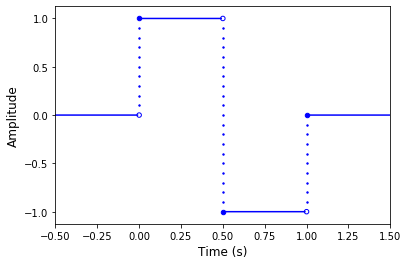

In [5]:
"""
Visualize haar wavelet
"""
import pywt
import matplotlib.pyplot as plt

xr=np.linspace(-1,2,10000)

def haar(x):
    hx=np.zeros(len(x))
    hx[np.where(x<1)]=-1
    hx[np.where(x<0.5)]=1
    hx[np.where(x<0)]=0
    return hx

fig,ax=plt.subplots(1, 1)
ax.plot(np.linspace(-1,-10e-3,10000),haar(np.linspace(-1,-10e-3,10000)), color='blue')
ax.plot(np.linspace(0,0.5-10e-3,10000),haar(np.linspace(0,0.5-10e-3,10000)), color='blue')
ax.plot(np.linspace(0.5,1-10e-3,10000),haar(np.linspace(0.5,1-10e-3,10000)),color='blue')
ax.plot(np.linspace(1,1.5,10000),haar(np.linspace(1,1.5,10000)),color='blue')

ax.scatter(np.zeros(10),np.linspace(0.1,1,10),s=2, color='blue')
ax.scatter(np.ones(20)*.5,np.linspace(0.9,-1,20),s=2, color='blue')
ax.scatter(np.ones(10),np.linspace(-0.9,0,10),s=2,  color='blue')

ax.scatter(0,0, s=20,facecolors='none', edgecolors='blue')
ax.scatter(0,1, s=20,facecolors='blue',edgecolors='blue')
ax.scatter(0.5,1, s=20,facecolors='none', edgecolors='blue')
ax.scatter(0.5,-1, s=20,facecolors='blue',edgecolors='blue')
ax.scatter(1,-1, s=20,facecolors='none', edgecolors='blue')
ax.scatter(1,0, s=20,facecolors='blue', edgecolors='blue')

ax.set_xlabel("Time (s)",fontsize=12)
ax.set_ylabel("Amplitude",fontsize=12)
ax.set_xlim([-0.5,1.5])

(-1, 1)

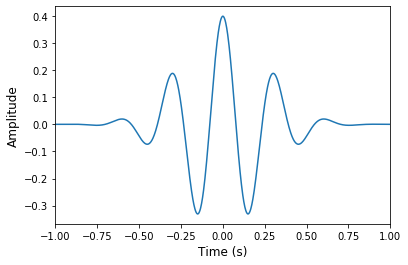

In [6]:
"""
Visualize Morlet wavelet
"""
import pywt
import matplotlib.pyplot as plt

xr=np.linspace(-4,4,1000)
yr=np.linspace(-1,1,1000)

def morl(x):
    return (2*np.pi)**(-.5)*np.exp(-x**2/2)*np.cos(2*np.pi*0.8*x)

fig,ax=plt.subplots(1, 1)
ax.plot(yr,morl(xr))
ax.set_xlabel("Time (s)",fontsize=12)
ax.set_ylabel("Amplitude",fontsize=12)
ax.set_xlim([-1,1])

C:\Users\Gabriel\Anaconda3\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


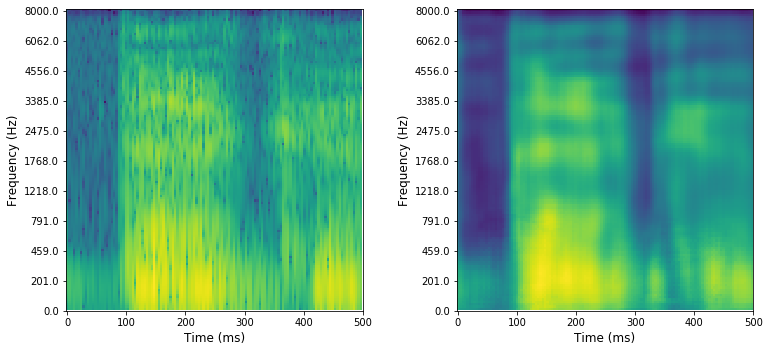

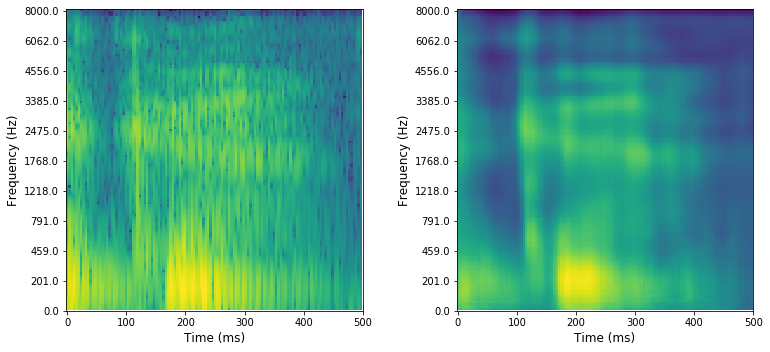

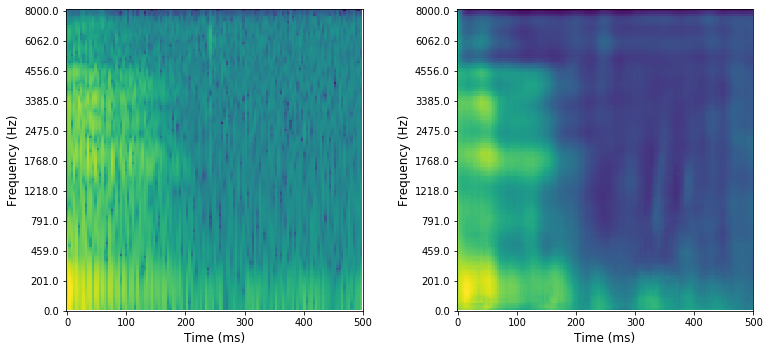

In [7]:
"""
Reconstruct speech representation for individual test speaker speech files based on CAE/RAE models for wvlt and spectral representations.
Test wav files not used for training.
"""
PATH=os.getcwd()

#SPECIFY path_audio and and file in directory
path_audio=PATH+'/pdSpanish/speech/pataka/pd/'
# path_audio=PATH+'/tedx_spanish_corpus/speech/test/'

spk=2
wav_file=path_audio+os.listdir(path_audio)[spk]

#SPECIFY model type and representation 
mod='CAE' #'CAE' or 'RAE'
rep='broadband' #'broadband/narrowband' => mel spectrogram, 'wvlt' => wavelet coefficients as features

if rep=='wvlt':
    TIME_STEPS=256
else:
    TIME_STEPS=126

fs_in, signal=read(wav_file)
signal=signal-np.mean(signal)
signal=signal/np.max(np.abs(signal))

#set loop parameters
unit=256
num_files=len(os.listdir(path_audio))
sig_len=len(signal) 

# for mod in models:
aespeech=AEspeech(model=mod,units=unit,rep=rep)
mat,to=aespeech.compute_rec_spectrogram(wav_file, return_numpy=False, plosives_only=0)

if rep=='spec' or rep=='narrowband' or rep=='broadband':
    spec_strt=5
    spec_end=8
    aespeech.show_spectrograms(sig_len=sig_len,spectrograms1=mat[spec_strt:spec_end,:,:,:],spectrograms2=to[spec_strt:spec_end,:,:,:])
if rep=='wvlt':
    freqs=mat[1]
    mat=mat[0]
    wv_strt=2
    wv_end=6
    aespeech.show_scalograms(np.arange(TIME_STEPS),coefs1=mat[wv_strt:wv_end,:,:,:],coefs2=to[wv_strt:wv_end,:,:,:], freqs=freqs, hop=2, yaxis='frequency', ylabel='frequency (Hz)')
if rep=='mc_fuse':
    for mat_c,to_c,rep_typ in zip(mat,to,['broadband','narrowband']):
        spec_strt=0
        spec_end=3
        aespeech.show_spectrograms(sig_len=sig_len,spectrograms1=mat_c[spec_strt:spec_end,:,:,:],spectrograms2=to_c[spec_strt:spec_end,:,:,:], title=rep_typ+" mel-spectrogram")


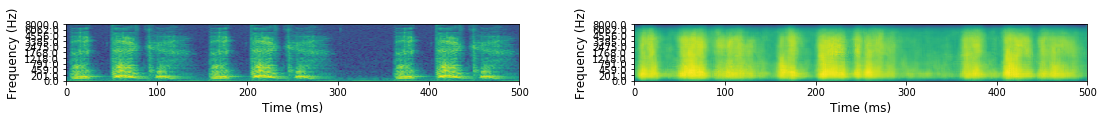

In [22]:
"""Visual of original signal (interpolated s.t. signal is of dim. 1024x128) and reconstructed"""

fs_in, signal=read(wav_file)
mmax=2595*np.log10(1+8000/700)

m=np.linspace(0,mmax,11)

f=np.round(700*(10**(m/2595)-1))
f=f[::-1]

FS=fs_in
rep='narrowband'

with open("config.json") as f:
    data = f.read()
config = json.loads(data)

TIME_STEPS=config['mel_spec']["FULL_TIME_STEPS"]
INTERP_NMELS=config['mel_spec']["INTERP_NMELS"]
NFFT=config['mel_spec']["NFFT"]

if rep=='broadband':
    WIN_LEN=int(config['mel_spec']["BB_TIME_WINDOW"]*FS)
    HOP=int(config['mel_spec']["BB_HOP"]*FS)
    NMELS=config['mel_spec']["BB_NMELS"]
else:
    WIN_LEN=int(config['mel_spec']["NB_TIME_WINDOW"]*FS)
    HOP=int(config['mel_spec']["NB_HOP"]*FS)
    NMELS=config['mel_spec']["NB_NMELS"]
    
# for mod in models:
aespeech=AEspeech(model=mod,units=unit,rep='full_'+rep)

fullmat=melspectrogram(signal.astype(float), sr=FS, n_fft=NFFT, win_length=WIN_LEN, hop_length=HOP, n_mels=NMELS, fmax=FS//2)
fullmat=fullmat[np.where(fullmat[:,0]>0)]
fullmat=np.abs(fullmat)
fullmat=np.log(fullmat, dtype=np.float32)

# if rep=='narrowband':
inter_mat=cv2.resize(fullmat,(TIME_STEPS,INTERP_NMELS),interpolation=cv2.INTER_CUBIC)
ae_mat=torch.zeros(1,1,INTERP_NMELS,TIME_STEPS)
tmat=torch.from_numpy(inter_mat)
ae_mat[0,0,:,:]=tmat

to, bot=aespeech.AE.forward(ae_mat)        
to=aespeech.destandard(to)

fig,ax=aespeech.show_spectrograms(sig_len, ae_mat, spectrograms2=to, title="",volta=1)
fig.set_size_inches(16,10)

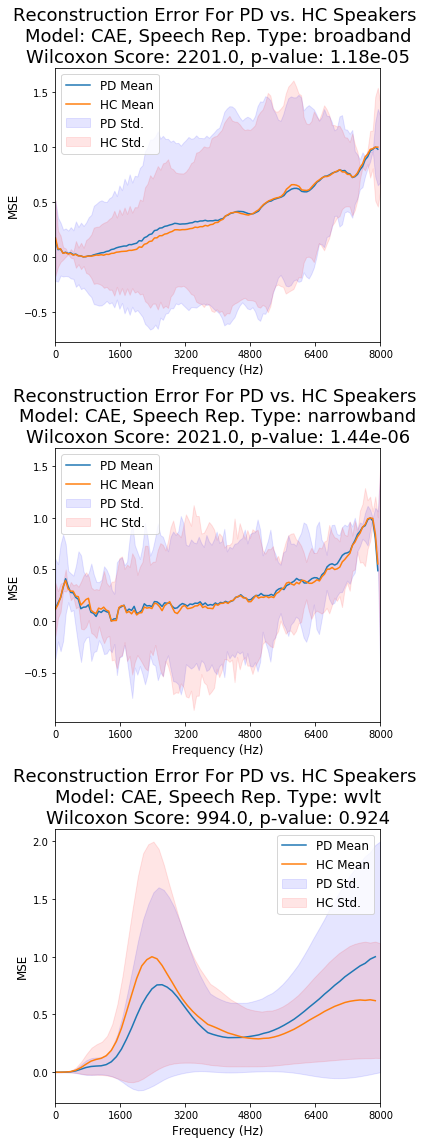

In [9]:
"""
VISUALIZE reconstruction error for pd vs. hc speakers for all utterance types 
FOR MULTI-CHANNEL fusion results, see cell below)
"""


cs=['b','r']

mods=['CAE']
reps=['broadband','narrowband','wvlt']
if len(reps)>1:
    fig,ax=plt.subplots(nrows=3,ncols=1, figsize=(6,16))
else:
    fig,ax=plt.subplots(nrows=3,ncols=1, figsize=(4,4))
for nmod,mod in enumerate(mods):
    for nrep,rep in enumerate(reps):
        load_path=PATH+'/pts/reconErrs/'+mod+'_'+rep+'.pickle'
        with open(load_path, 'rb') as handle:
            data = pickle.load(handle)
        if len(reps)==1:
            ax_curr=ax
        else:
            ax_curr=ax[nrep]
        
#         pop_mean=np.mean((data['pd']['means'],data['hc']['means']), axis=0)
#         pop_std=np.mean((data['pd']['stds'],data['hc']['stds']), axis=0)
        
        for nspk,spk in enumerate(['pd','hc']):
#             means=np.mean((data[spk]['means']-pop_mean)/pop_std,axis=0)
            means=np.abs(np.mean(data[spk]['means'],axis=0))
            means=(means-min(means))/(max(means)-min(means))
#             stds=np.mean((data[spk]['stds']-np.mean(data[spk]['stds'],axis=0))/np.std(data[spk]['stds'],axis=0),axis=0)
            stds=np.mean(data[spk]['stds'],axis=0)
            stds=(stds-min(stds))/(max(stds)-min(stds))
            
            under_line=means-stds
            over_line=means+stds

            ax_curr.plot(means)
            ax_curr.fill_between(np.linspace(0,len(stds),len(stds)), under_line, over_line, color=cs[nspk], alpha=.1)

            ax_curr.set_xticks(np.linspace(0,len(means),6))
            ax_curr.set_xticklabels(map(str, np.linspace(0,8000,6, dtype=np.int)))
            ax_curr.set_xlabel('Frequency (Hz)',fontsize=12)
            ax_curr.set_ylabel('MSE',fontsize=12)
            ax_curr.set_xlim([0,len(means)])
        #     ax.set_ylim([-.5,1])

            ax_curr.legend(['PD Mean','HC Mean','PD Std.','HC Std.'],fontsize=12)
            if nspk==0:
                pd_means=means
            else:
                hc_means=means
                
        ttl="Reconstruction Error For PD vs. HC Speakers \nModel: "+mod+", Speech Rep. Type: "+rep+\
            '\nWilcoxon Score: '+str(scipy.stats.wilcoxon(pd_means,hc_means)[0])+\
            ", p-value: "+str('{:.3g}'.format(scipy.stats.wilcoxon(pd_means,hc_means)[1],3))
        
        ax_curr.set_title(ttl,fontsize=18)
plt.tight_layout()
            
        

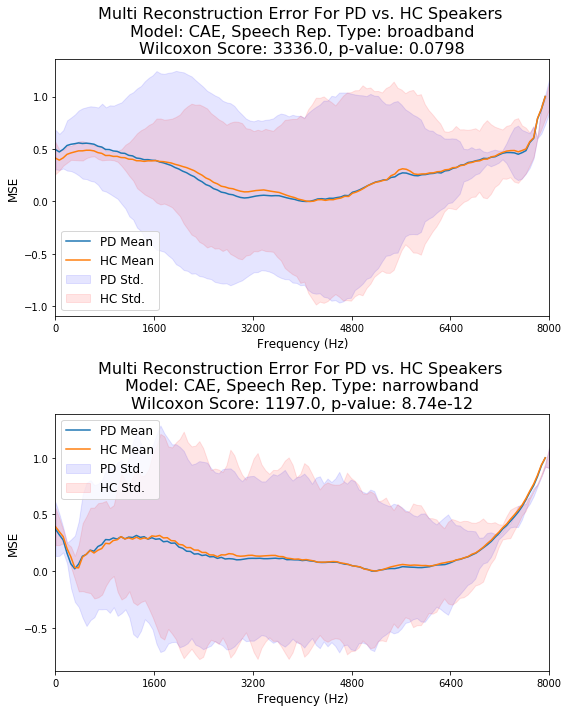

In [10]:
"""
VISUALIZE reconstruction error for pd vs. hc speakers for all utterance types 
(MULTI-CHANNEL fusion results)
"""
fig,ax=plt.subplots(nrows=2,ncols=1, figsize=(8,10))
cs=['b','r']

mods=['CAE']
reps=['broadband', 'narrowband']

with open("config.json") as f:
    data = f.read()
config = json.loads(data)
n_freqs=config['mel_spec']['INTERP_NMELS']

for nmod,mod in enumerate(mods):
    for nrep,rep in enumerate(reps):
        load_path=PATH+'/pts/reconErrs/'+mod+'_mc_fuse.pickle'
        with open(load_path, 'rb') as handle:
            data = pickle.load(handle)
     
        ax_curr=ax[nrep]
        for nspk,spk in enumerate(['pd','hc']):
            means=np.abs(np.mean(data[spk]['means'][:,nrep*n_freqs:n_freqs*(nrep+1)],axis=0))
            means=(means-min(means))/(max(means)-min(means))
            stds=np.mean(data[spk]['stds'][:,nrep*n_freqs:n_freqs*(nrep+1)],axis=0)
            stds=(stds-min(stds))/(max(stds)-min(stds))
            under_line=means-stds
            over_line=means+stds

            ax_curr.plot(means)
            ax_curr.fill_between(np.linspace(0,len(stds),len(stds)), under_line, over_line, color=cs[nspk], alpha=.1)
            
            ax_curr.set_xticks(np.linspace(0,len(means),6))
            ax_curr.set_xticklabels(map(str, np.linspace(0,8000,6, dtype=np.int)))
            ax_curr.set_xlabel('Frequency (Hz)',fontsize=12)
            ax_curr.set_ylabel('MSE',fontsize=12)
            ax_curr.set_xlim([0,len(means)])

            ax_curr.legend(['PD Mean','HC Mean','PD Std.','HC Std.'],fontsize=12)
            if nspk==0:
                pd_means=means
            else:
                hc_means=means

        ttl="Multi Reconstruction Error For PD vs. HC Speakers \nModel: "+mod+", Speech Rep. Type: "+rep+\
        '\nWilcoxon Score: '+str(scipy.stats.wilcoxon(pd_means,hc_means)[0])+\
        ", p-value: "+str('{:.3g}'.format(scipy.stats.wilcoxon(pd_means,hc_means)[1]))
        ax_curr.set_title(ttl,fontsize=16)
        
plt.tight_layout()

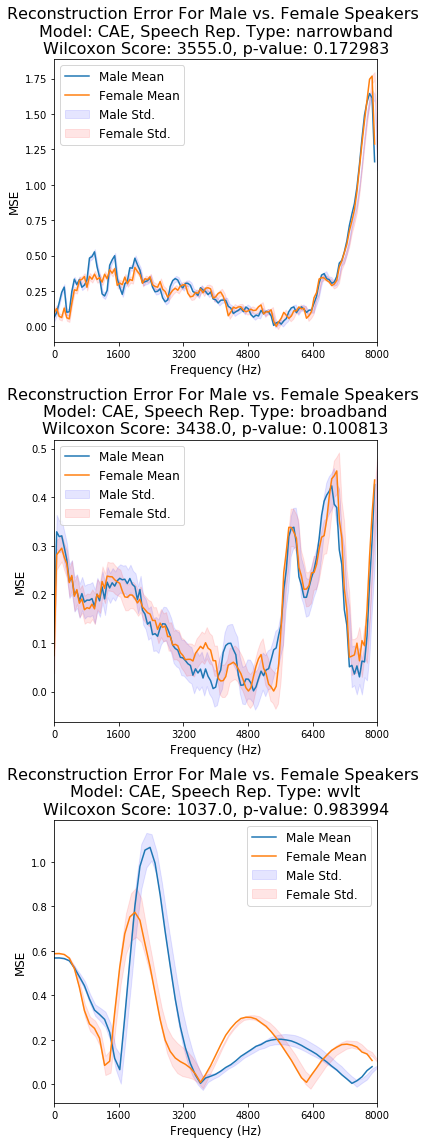

In [23]:
"""
VISUALIZE reconstruction error for male vs. female and pd vs. hc speakers for all individual utterance types.
"""

fig,ax=plt.subplots(nrows=3,ncols=1, figsize=(6,16))
cs=['b','r']

mods=['CAE']
reps=['narrowband','broadband','wvlt']

for nmod,mod in enumerate(mods):
    for nrep,rep in enumerate(reps):
        load_path=PATH+'/pts/reconErrs/'+mod+'_'+rep+'_gender.pickle'
        with open(load_path, 'rb') as handle:
            data = pickle.load(handle)
     
       
        for gItr,gender in enumerate(['m','f']):
            ax_curr=ax[nrep]
            ovrall_num_frs=np.shape(data['pd'][gender]['means'])[1]
            ovrall_means=np.zeros((ovrall_num_frs,2))
            ovrall_stds=np.zeros((ovrall_num_frs,2))  
            
            for nspk,spk in enumerate(['pd','hc']):
                means=np.abs(np.mean(data[spk][gender]['means'],axis=0))
                stds=np.mean(data[spk][gender]['stds'],axis=0)
                ovrall_means[:,gItr]=means
                ovrall_stds[:,gItr]=stds

            ovrall_means=np.mean(ovrall_means,axis=1)
            ovrall_stds=np.mean(ovrall_stds,axis=1)
            ax_curr.plot(ovrall_means)
            u_line=ovrall_means-ovrall_stds
            o_line=ovrall_means+ovrall_stds
            ax_curr.fill_between(np.linspace(0,len(ovrall_stds),len(ovrall_stds)), u_line, o_line, color=cs[gItr], alpha=.1)
            if gItr==0:
                m_means=ovrall_means
                m_stds=ovrall_stds
                    
        ttl="Reconstruction Error For Male vs. Female Speakers \nModel: "+mod+", Speech Rep. Type: "+rep+\
                '\nWilcoxon Score: '+str(scipy.stats.wilcoxon(m_means,ovrall_means)[0])+\
                ", p-value: "+str('{:.6g}'.format(scipy.stats.wilcoxon(m_means,ovrall_means)[1]))

        ax_curr.set_title(ttl,fontsize=16)
        ax_curr.set_xticks(np.linspace(0,len(ovrall_means),6))
        ax_curr.set_xticklabels(map(str, np.linspace(0,8000,6, dtype=np.int)))
        ax_curr.set_xlabel('Frequency (Hz)',fontsize=12)
        ax_curr.set_ylabel('MSE',fontsize=12)
        ax_curr.set_xlim([0,len(ovrall_means)])
        #     ax.set_ylim([-.5,1])

        ax_curr.legend(['Male Mean','Female Mean','Male Std.','Female Std.'],fontsize=12)

plt.tight_layout()

In [ ]:
"""
VISUALIZE reconstruction error for male vs. female for multi channel representation.
"""

fig,ax=plt.subplots(nrows=2,ncols=1, figsize=(8,10))
cs=['b','r']

mods=['CAE']
reps=['narrowband','broadband']

with open("config.json") as f:
    data = f.read()
config = json.loads(data)
n_freqs=config['mel_spec']['INTERP_NMELS']

for nmod,mod in enumerate(mods):
    load_path=PATH+'/pts/reconErrs/'+mod+'_mc_fuse_gender.pickle'
    with open(load_path, 'rb') as handle:
        data = pickle.load(handle)
    for nrep,rep in enumerate(reps):
        for gItr,gender in enumerate(['m','f']):
            ax_curr=ax[nrep]
            ovrall_num_frs=n_freqs
            ovrall_means=np.zeros((ovrall_num_frs,2))
            ovrall_stds=np.zeros((ovrall_num_frs,2))  
            
            for nspk,spk in enumerate(['pd','hc']):
                means=np.abs(np.mean(data[spk][gender]['means'][:,nrep*n_freqs:n_freqs*(nrep+1)],axis=0))
                stds=np.mean(data[spk][gender]['stds'][:,nrep*n_freqs:n_freqs*(nrep+1)],axis=0)
                ovrall_means[:,gItr]=means
                ovrall_stds[:,gItr]=stds
                
            ovrall_means=np.mean(ovrall_means,axis=1)
            ovrall_stds=np.mean(ovrall_stds,axis=1)
            ax_curr.plot(ovrall_means)
            u_line=ovrall_means-ovrall_stds
            o_line=ovrall_means+ovrall_stds
            ax_curr.fill_between(np.linspace(0,len(ovrall_stds),len(ovrall_stds)), u_line, o_line, color=cs[gItr], alpha=.1)
            if gItr==0:
                m_means=ovrall_means
                m_stds=ovrall_stds
                    
        ttl="Multi-Channel Reconstruction Error For Male vs. Female Speakers \nModel: "+mod+", Speech Rep. Type: "+rep+\
                '\nWilcoxon Score: '+str(scipy.stats.wilcoxon(m_means,ovrall_means)[0])+\
                ", p-value: "+str('{:.6g}'.format(scipy.stats.wilcoxon(m_means,ovrall_means)[1]))

        ax_curr.set_title(ttl,fontsize=16)
        ax_curr.set_xticks(np.linspace(0,len(ovrall_means),6))
        ax_curr.set_xticklabels(map(str, np.linspace(0,8000,6, dtype=np.int)))
        ax_curr.set_xlabel('Frequency (Hz)',fontsize=12)
        ax_curr.set_ylabel('MSE',fontsize=12)
        ax_curr.set_xlim([0,len(ovrall_means)])
        #     ax.set_ylim([-.5,1])

        ax_curr.legend(['Male Mean','Female Mean','Male Std.','Female Std.'],fontsize=12)

plt.tight_layout()

            
        